In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Import additional library to properply play videos on jupyter notebook
from IPython.display import clear_output

In [3]:
imgR = cv2.imread('right.png')
imgL = cv2.imread('left.png')
#Proceed only if the frames have been captured

imgR = cv2.cvtColor(imgR,cv2.COLOR_BGR2GRAY)
imgL = cv2.cvtColor(imgL,cv2.COLOR_BGR2GRAY)
      
# Detecting keypoints and thier descriptors
sift= cv2.xfeatures2d.SIFT_create()
kpL, desL = sift.detectAndCompute(imgL, None)
kpR, desR = sift.detectAndCompute(imgR, None)


In [4]:
# Visualize keypoints
imgSift = cv2.drawKeypoints(
    imgL, kpL, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imshow("SIFT Keypoints", imgSift)

In [5]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(desL, desR, k=2)

# Keep good matches: calculate distinctive image features
# Lowe, D.G. Distinctive Image Features from Scale-Invariant Keypoints. International Journal of Computer Vision 60, 91–110 (2004). https://doi.org/10.1023/B:VISI.0000029664.99615.94
# https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
ptsL = []
ptsR = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        ptsR.append(kpR[m.trainIdx].pt)
        ptsL.append(kpL[m.queryIdx].pt)

In [7]:
# Draw the keypoint matches between both pictures

draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask[300:500],
                   flags=cv2.DrawMatchesFlags_DEFAULT)

keypoint_matches = cv2.drawMatchesKnn(
    imgL, kpL, imgR, kpR, matches[300:500], None, **draw_params)
cv2.imshow("Keypoint matches", keypoint_matches)
cv2.waitKey(500)


-1

In [8]:

# Calculate the fundamental matrix for the cameras

ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)
fundamental_matrix, inliers = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_RANSAC)

# We select only inlier points

ptsL = ptsL[inliers.ravel() == 1]
ptsR = ptsR[inliers.ravel() == 1]

In [9]:
def drawlines(imgLsrc, imgRsrc, lines, ptsLsrc, ptsRsrc):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c = imgLsrc.shape
    imgLcolor = cv2.cvtColor(imgLsrc, cv2.COLOR_GRAY2BGR)
    imgRcolor = cv2.cvtColor(imgRsrc, cv2.COLOR_GRAY2BGR)
    
    # Edit: use the same random seed so that two images are comparable!
    
    np.random.seed(0)
    for r, ptL, ptR in zip(lines, ptsLsrc, ptsRsrc):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1color = cv2.line(imgLcolor, (x0, y0), (x1, y1), color, 1)
        img1color = cv2.circle(imgLcolor, tuple(ptL), 5, color, -1)
        img2color = cv2.circle(imgRcolor, tuple(ptR), 5, color, -1)
    return imgLcolor, imgRcolor

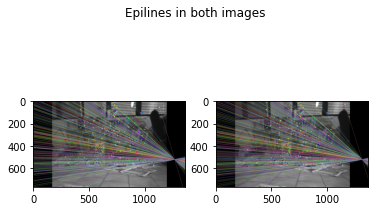

In [10]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image

linesL = cv2.computeCorrespondEpilines(
    ptsR.reshape(-1, 1, 2), 2, fundamental_matrix)
linesL = linesL.reshape(-1, 3)
img5, img6 = drawlines(imgL, imgR, linesL, ptsL, ptsR)


# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image

linesR = cv2.computeCorrespondEpilines(
    ptsL.reshape(-1, 1, 2), 1, fundamental_matrix)
linesR = linesR.reshape(-1, 3)
img3, img4 = drawlines(imgR, imgL, linesR, ptsR, ptsL)

plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.suptitle("Epilines in both images")
plt.show()

In [11]:
# Stereo rectification (uncalibrated variant)

print(imgL.shape)
hL, wL = imgL.shape
hR, wR = imgR.shape
_, HL, HR = cv2.stereoRectifyUncalibrated(
    np.float32(ptsL), np.float32(ptsR), fundamental_matrix, imgSize=(wL, hL)
)

(768, 1366)


In [12]:
# Undistort (rectify) the images and save them

imgL_rectified = cv2.warpPerspective(imgL, HL, (wL, hL))
imgR_rectified = cv2.warpPerspective(imgR, HR, (wR, hR))
cv2.imwrite("rectified_left.png", imgL_rectified)
cv2.imwrite("rectified_right.png", imgR_rectified)

True

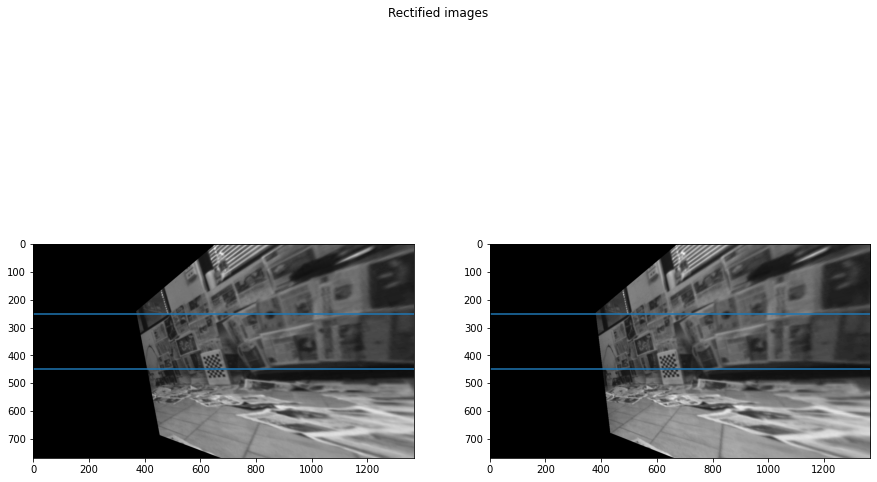

In [13]:
# Draw the rectified images

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(imgL_rectified, cmap="gray")
axes[1].imshow(imgR_rectified, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.suptitle("Rectified images")
plt.savefig("rectified_images.png")
plt.show()

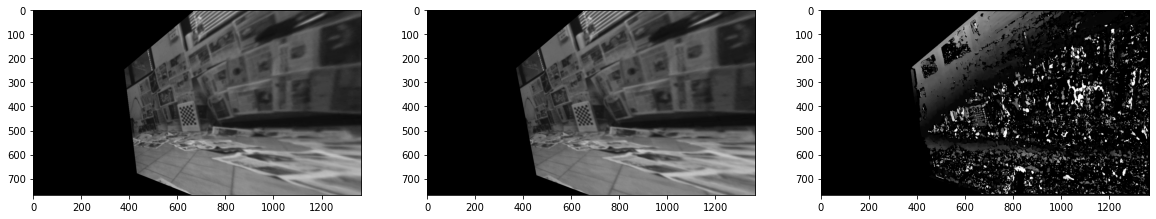

In [14]:
plt.figure(figsize=(20, 10))

plt.subplot(1,3,1)
plt.imshow(imgR_rectified, cmap='gray', vmin=0, vmax=255)
plt.subplot(1,3,2)
plt.imshow(imgL_rectified, cmap='gray', vmin=0, vmax=255)
plt.subplot(1,3,3)
stereo = cv2.StereoBM_create(numDisparities=32, blockSize=11)
disparity = stereo.compute(imgR_rectified,imgL_rectified)
plt.imshow(disparity,'gray')
plt.show()